In [1]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, ".."))

from stats.common import comparisons

run_results = pd.read_parquet(
    os.path.abspath(os.path.join(notebook_dir, "../../cache/parquet/analysis_3.parquet"))
)

comparisons

['qb1',
 'wr1',
 'wr2',
 'wr3',
 'rb1',
 'rb2',
 'passing',
 'receiving',
 'rushing',
 'team',
 'starters',
 'usage']

In [2]:
total = len(run_results.index)


def process_totals():
    print("total", len(run_results.index))
    print("home selected", len(run_results[run_results["grade"] >= 2].index) / total)
    print("away selected", len(run_results[run_results["grade"] <= -2].index) / total)
    print("unknown", len(run_results[run_results["grade"].abs() == 1].index) / total)


def analyze_boundries(label, boundry):
    print(f"---{label}---")
    chosen = run_results[run_results[label].abs() >= boundry]

    correct = chosen[
        ((chosen[label] >= boundry) & (chosen["expected"] == True))
        | ((chosen[label] <= -boundry) & (chosen["expected"] == False))
    ]

    home_selected = chosen[(chosen[label] >= boundry)]
    home_correct = correct[(correct[label] >= boundry)]

    if len(chosen.index) == 0:
        print("nothing chosen")
    else:
        print("accuracy", len(correct.index) / len(chosen.index))
        print("chosen", len(chosen.index), len(chosen.index) / total)
        print("correct", len(correct.index))
        print("home_selected", len(home_selected.index))
        print("home_correct", len(home_correct.index))


process_totals()
analyze_boundries("grade", 2)
for compare in comparisons:
    analyze_boundries(compare, 50)

total 1921
home selected 0.44299843831337843
away selected 0.491410723581468
unknown 0.06559083810515356
---grade---
accuracy 0.5894150417827299
chosen 1795 0.9344091618948465
correct 1058
home_selected 851
home_correct 537
---qb1---
accuracy 0.6410256410256411
chosen 468 0.24362311296199896
correct 300
home_selected 219
home_correct 150
---wr1---
accuracy 0.5573979591836735
chosen 784 0.4081207704320666
correct 437
home_selected 377
home_correct 228
---wr2---
accuracy 0.5377777777777778
chosen 675 0.35137948984903694
correct 363
home_selected 338
home_correct 190
---wr3---
accuracy 0.5194805194805194
chosen 616 0.3206663196251952
correct 320
home_selected 282
home_correct 159
---rb1---
accuracy 0.5783274440518257
chosen 849 0.44195731389901094
correct 491
home_selected 407
home_correct 253
---rb2---
accuracy 0.5602716468590832
chosen 589 0.30661114003123374
correct 330
home_selected 275
home_correct 165
---passing---
accuracy 0.6285046728971962
chosen 428 0.22280062467464862
correct 2

In [3]:
import numpy as np
import seaborn as sbn

from scipy import stats

reduced = run_results[
    (np.abs(stats.zscore(run_results[comparisons])) < 3).all(axis=1)
].copy()

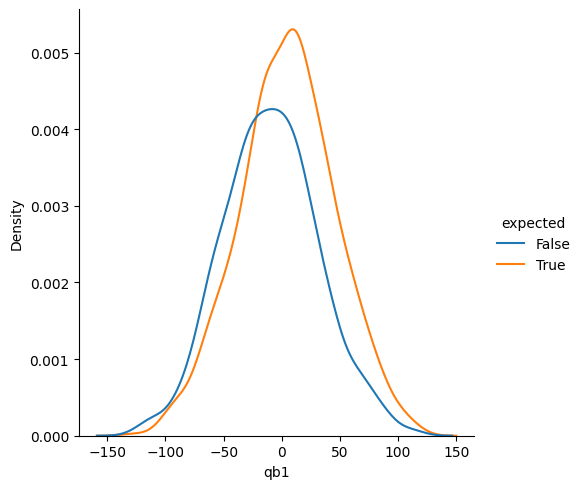

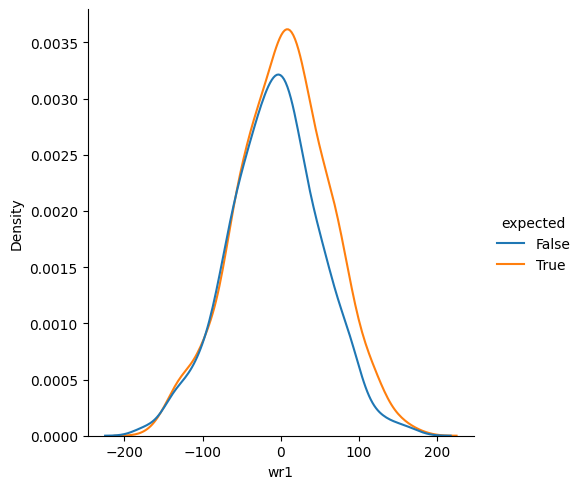

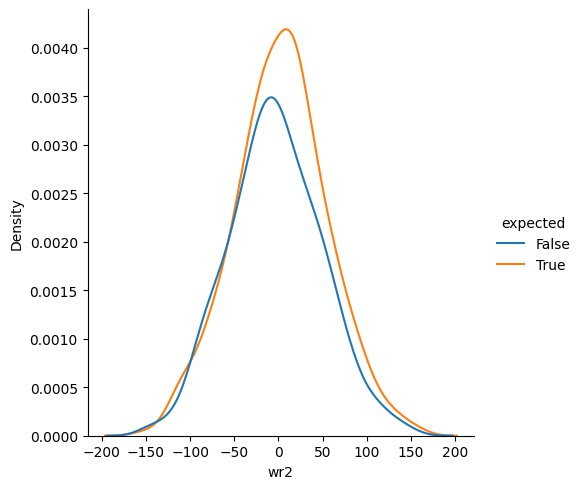

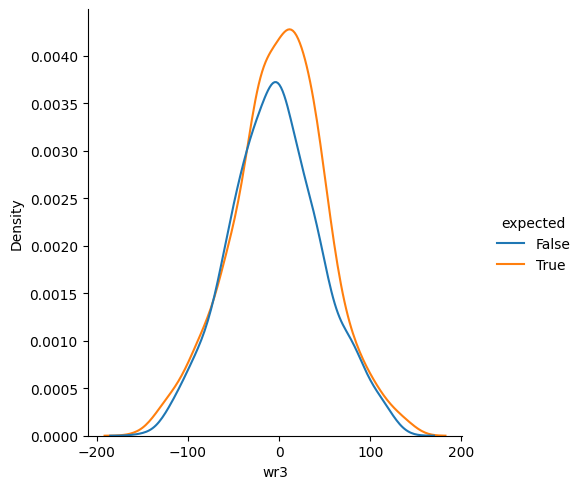

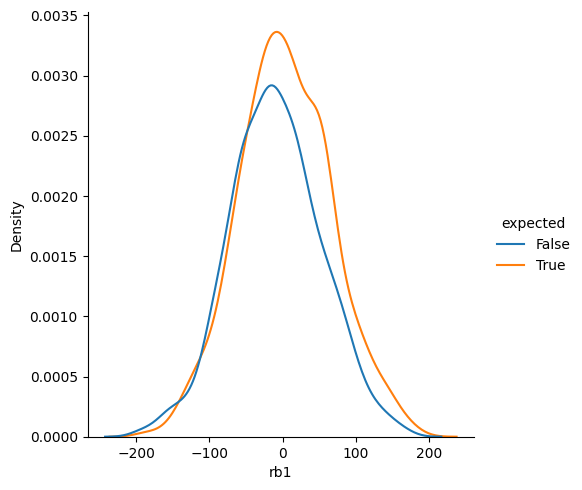

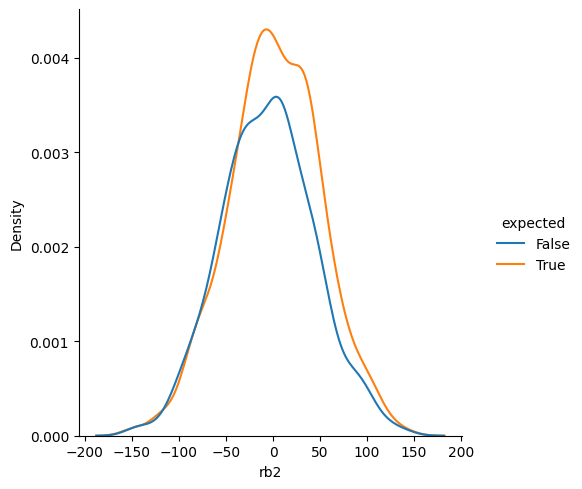

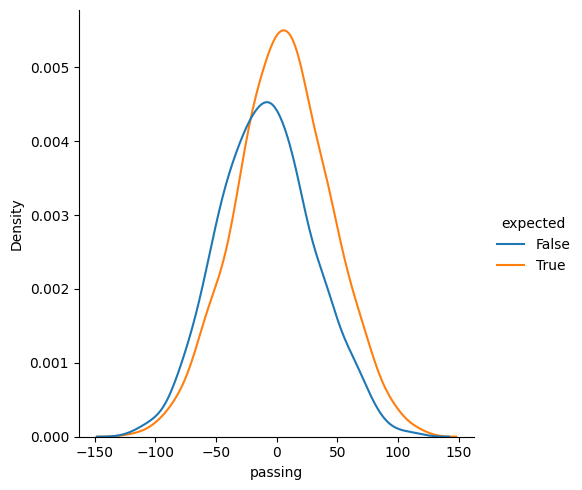

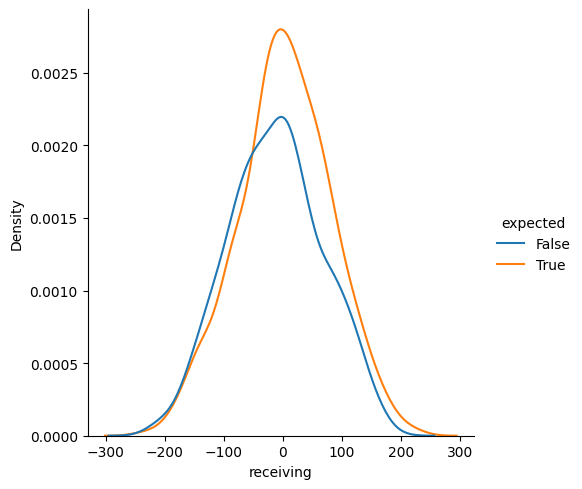

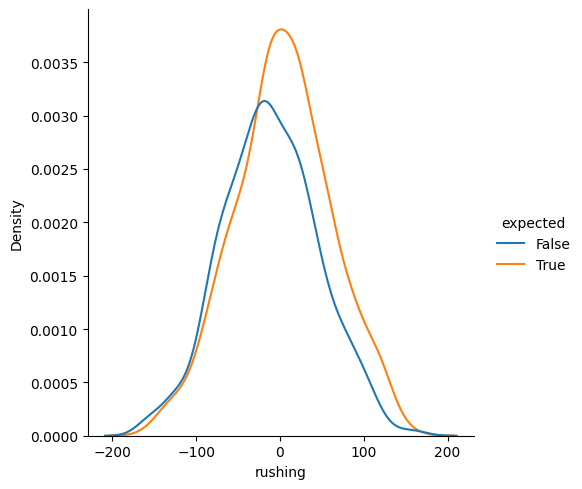

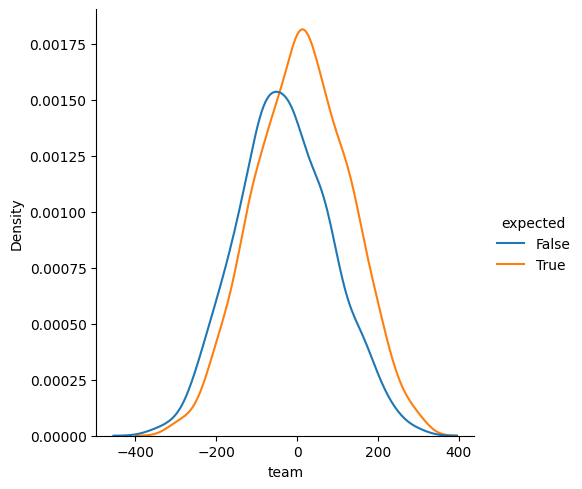

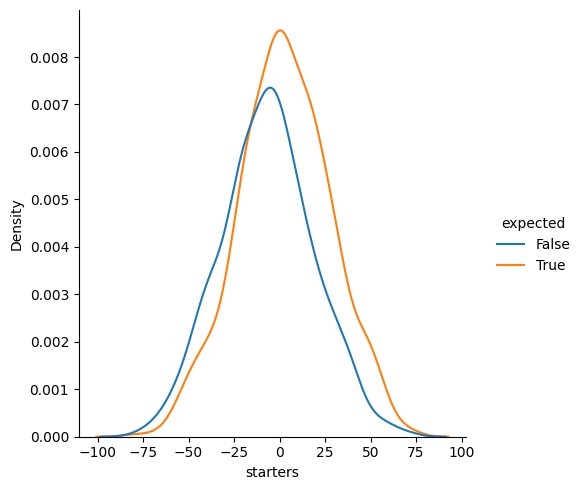

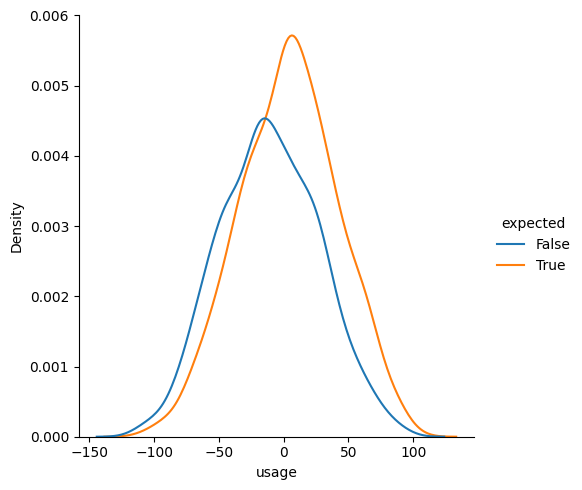

In [4]:
for compare in comparisons:
    sbn.displot(data=reduced, x=compare, hue="expected", kind="kde")

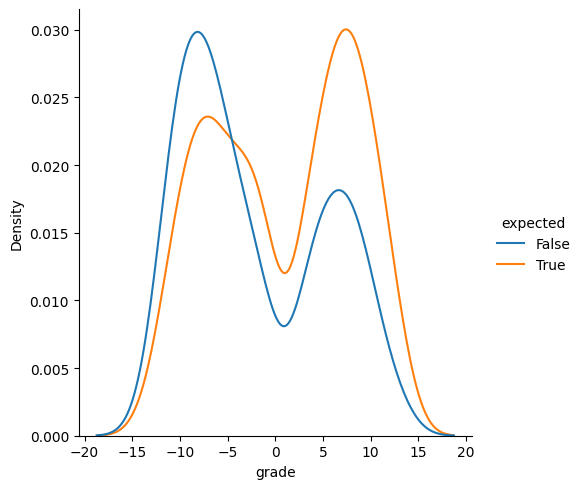

In [5]:
sbn.displot(data=reduced, x="grade", hue="expected", kind="kde")

In [6]:
from scipy.stats import pearsonr, spearmanr


# Calculate Pearson correlation
def show_correlation(column: str, compare: str):
    print(f"Show correlation of: {column} vs {compare}")

    pearson_corr, _ = pearsonr(reduced[column], reduced[compare])
    print(f"Pearson correlation: {pearson_corr}")

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(reduced[column], reduced[compare])
    print(f"Spearman correlation: {spearman_corr}")


for compare in comparisons + ["grade"]:
    show_correlation(compare, "expected")

Show correlation of: qb1 vs expected
Pearson correlation: 0.17389327976026345
Spearman correlation: 0.17716743395052578
Show correlation of: wr1 vs expected
Pearson correlation: 0.08993561020324664
Spearman correlation: 0.09223317382341516
Show correlation of: wr2 vs expected
Pearson correlation: 0.057518119242040144
Spearman correlation: 0.06105693926935915
Show correlation of: wr3 vs expected
Pearson correlation: 0.04680956851609247
Spearman correlation: 0.05845991399014005
Show correlation of: rb1 vs expected
Pearson correlation: 0.10724667307746014
Spearman correlation: 0.10480269663347946
Show correlation of: rb2 vs expected
Pearson correlation: 0.07531308701939474
Spearman correlation: 0.08050281232103117
Show correlation of: passing vs expected
Pearson correlation: 0.17107757299714055
Spearman correlation: 0.17285231537785697
Show correlation of: receiving vs expected
Pearson correlation: 0.09997853209859403
Spearman correlation: 0.10086738803656169
Show correlation of: rushing 

In [7]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc


def find_threshold(field, target=0.6):
    new_field = f"prob_{field}"
    reduced[new_field] = (reduced[field] - reduced[field].min()) / (
        reduced[field].max() - reduced[field].min()
    )

    fpr, tpr, thresholds = roc_curve(reduced["expected"], reduced[new_field])
    roc_auc = auc(fpr, tpr)
    print(f"Area under the ROC curve for {field}: {roc_auc}")

    ####################################
    # The optimal cut off would be where tpr is high and fpr is low
    # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
    ####################################
    i = np.arange(len(tpr))  # index for df
    roc = pd.DataFrame(
        {
            "fpr": pd.Series(fpr, index=i),
            "tpr": pd.Series(tpr, index=i),
            "1-fpr": pd.Series(1 - fpr, index=i),
            "tf": pd.Series(tpr - (1 - fpr), index=i),
            "diff": pd.Series((1 - fpr) - tpr, index=i),
            "thresholds": pd.Series(thresholds, index=i),
        }
    )

    # This gives where the two values are .7 apart
    pos = (np.abs(roc["diff"] - target)).idxmin()

    # This gives you where the lines cross
    # pos = (roc.tf-0).abs().argsort()[:1]
    ideal = {str(key): float(value) for key, value in roc.iloc[pos].items()}
    print(ideal)
    target = (
        ideal["thresholds"] * (reduced[field].max() - reduced[field].min())
        + reduced[field].min()
    )
    print("threshold value =>", target, "\n")

    # Plot tpr vs 1-fpr
    """
    fig, ax = pl.subplots()
    pl.plot(roc['tpr'])
    pl.plot(roc['1-fpr'], color = 'red')
    pl.xlabel('1-False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(field)
    ax.set_xticklabels([])
    """
    return int(target)


targets = {
    comparison: find_threshold(comparison) for comparison in comparisons + ["grade"]
}

print(targets)

Area under the ROC curve for qb1: 0.6026641315933512
{'fpr': 0.14619883040935672, 'tpr': 0.25320197044334974, '1-fpr': 0.8538011695906433, 'tf': -0.6005991991472936, 'diff': 0.6005991991472936, 'thresholds': 0.6493350204531353}
threshold value => 32.39514036384412 

Area under the ROC curve for wr1: 0.5534468354795034
{'fpr': 0.16842105263157894, 'tpr': 0.23645320197044334, '1-fpr': 0.8315789473684211, 'tf': -0.5951257453979777, 'diff': 0.5951257453979777, 'thresholds': 0.6306551745820508}
threshold value => 46.88929866429868 

Area under the ROC curve for wr2: 0.5353809811886037
{'fpr': 0.19181286549707602, 'tpr': 0.20985221674876847, '1-fpr': 0.808187134502924, 'tf': -0.5983349177541555, 'diff': 0.5983349177541555, 'thresholds': 0.6263937128503768}
threshold value => 42.99978956228955 

Area under the ROC curve for wr3: 0.533876069484055
{'fpr': 0.19181286549707602, 'tpr': 0.20886699507389161, '1-fpr': 0.808187134502924, 'tf': -0.5993201394290324, 'diff': 0.5993201394290324, 'thresho

In [8]:
def analyze(targets):
    filters = None
    for comparison in comparisons:
        value = targets[comparison]
        filter = (run_results[comparison].abs() >= value)

        if filters is None:
            filters = filter
        else:
            filters = filters & filter

    chosen = run_results[filters].reset_index(drop=True)

    positive = chosen["expected"] == True
    negative = chosen["expected"] == False

    for comparison in comparisons:
        value = targets[comparison]
        positive = positive & (chosen[comparison] >= value)
        negative = negative & (chosen[comparison] <= -value)
        # chosen[comparison] = chosen[comparison].astype(int)

    sub = (positive) | (negative)

    correct = chosen[sub]
    chosen["correct"] = False
    chosen.loc[sub, "correct"] = True

    print("chosen", len(chosen.index), len(chosen.index) / total)
    print("correct", len(correct.index), len(correct.index) / len(chosen.index))

    print(correct)
    chosen[
        [
            "season",
            "week",
            "expected",
            "correct",
            "diff",
        ]
        + comparisons
    ].to_parquet(
        os.path.abspath(
            os.path.join(notebook_dir, f"../../cache/parquet/chosen.parquet")
        )
    )


# analyze(154, 178, 308) => 0.65 0.22
analyze(targets)

chosen 5 0.0026028110359187923
correct 1 0.2
   season  week home away         qb1        wr1         wr2        wr3  \
2    2019     2  DAL  MIA  182.670192  69.121917  241.195052  45.128792   

         rb1        rb2     passing   receiving     rushing        team  \
2  75.231487  52.160367  178.031997  322.953987  143.297564  547.373016   

     starters       usage  grade                            results  expected  \
2  110.917968  214.761183     13  {'loser': 'MIA', 'winner': 'DAL'}      True   

   diff  
2    25  
